# Foundations of Data Mining: Fashion-MNIST Challenge

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [ ]:
# Please fill in your names here
NAME_STUDENT_1 = "Rashmi Kamath 1281879"

In [139]:
%matplotlib inline
from preamble import *
plt.rcParams['figure.dpi'] = 200 # This controls the size of your figures
plt.rcParams['savefig.dpi'] = 200 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "all" 
import sklearn.decomposition as deco
from sklearn.cluster import KMeans 
from sklearn.metrics import confusion_matrix

## Fashion-MNIST
The [Fashion-MNIST dataset](https://www.openml.org/d/40996) contains 70,000 images of Zalando fashion products, classified into 10 types of clothing, each represented by 28 by 28 pixel values. We can easily download it from OpenML and visualize one of the examples:

In [140]:
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [141]:
fmnist_data = oml.datasets.get_dataset(40996) # Download MNIST data
# Get the predictors X and the labels y
X, y = fmnist_data.get_data(target=fmnist_data.default_target_attribute); 

In [142]:
# build a list of figures for plotting
def buildFigureList(fig, subfiglist, titles, length):
    
    for i in range(0,length):
        pixels = np.array(subfiglist[i], dtype='float')
        pixels = pixels.reshape((28, 28))
        a=fig.add_subplot(1,length,i+1)
        imgplot =plt.imshow(pixels, cmap='gray_r')
        a.set_title(titles[i], fontsize=6)
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    return

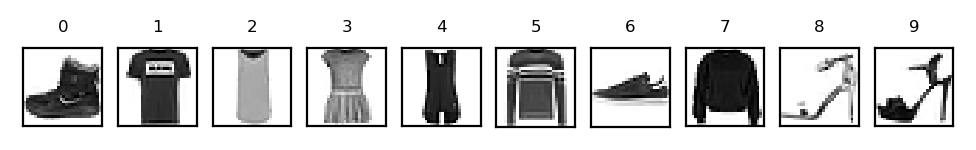

In [143]:
subfiglist = []
titles=[]

for i in range(0,10):
    subfiglist.append(X[i])
    titles.append(i)

buildFigureList(plt.figure(1),subfiglist, titles, 10)
plt.show()

## Question 2. Analyzing image data with neural embedding

*In this part of the assignment, rather than working on the whole dataset you will implement representation learning on one part of the data and analyze the second part of the data with the learned representations.*

Use the provided code to split the training dataset in two subset based on their class labels. Dataset 1, containing classes 0 to 4 and Dataset 2 classes 5 to 9. 

### a ) Develop a model for learning representations (4 points)

Develop a convolutional neural network model for classification on Dataset 1 using the Keras python library.

You are free to choose your model architecture such that:
- You need to justify the decisions for selecting the layers, activation functions and loss function. (Add a text cell where you can write your justification)
- Your model must have one dense layer with 64 neurons and ReLU activation that is not the first nor the last layer in the model. We will refer to this layer as a 'neural code' (set **name='neural_codes'** parameter in your code for that layer).


In [144]:
# Do not modify this cell
# Extra imports for kears layers, matplotlib and nearestneigbors
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation
from keras.utils import to_categorical
from keras import backend as K
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [145]:
## Do not modify this cell
# Load and reshape the data
img_rows, img_cols, chns = 28, 28, 1
n_classes = 10

x_train = X
y_train = y

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    #x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    #x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

    y_train = to_categorical(y_train, n_classes)

    
# Split the data in two datasets 
indexes1 = np.where(np.argmax(y_train, axis=1) <= 4)
indexes2 = np.where(np.argmax(y_train, axis=1) > 4)
dataset_1 = x_train[indexes1]
y_dataset1 = y_train[indexes1]
dataset_2 = x_train[indexes2]
y_dataset2 = y_train[indexes2]

print ("Dataset 1 shape: ", dataset_1.shape)    
print ("Dataset 2 shape: ", dataset_2.shape)    
print("Dataset 1 labels shape: ", y_dataset1.shape)
print("Dataset 2 labels shape: ", y_dataset2.shape)


Dataset 1 shape:  (35000, 28, 28, 1)
Dataset 2 shape:  (35000, 28, 28, 1)
Dataset 1 labels shape:  (35000, 10)
Dataset 2 labels shape:  (35000, 10)


In [146]:
# Implement your model here

# model = 
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(Activation('relu'))
#normalizes the activations in the previous layer 
#transformation maintains the mean activation close to 0 std close to 1
#the scale of each dimension remains the same
#reduces running-time of training significantly
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#flattening layer 
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,activation='relu', name='neural_codes'))
model.add(Activation('relu'))
model.add(BatchNormalization())
#regularization helps to avoid overfitting
model.add(Dropout(0.3))
model.add(Dense(10,activation="softmax"))

#multiclass classification: cross-entropy loss-function with ADAM optimizer
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

print('model Build')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_52 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_53 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 12, 12, 32)        128       
__________

##### Justification of model architecture 
1. sequential: It is to initiate the model 
2. Convolution Layer: It is used in recognizing the image. I define 32 filters for the first 2 convolutional layer and later define 32 and 64 filters, we use 3. 3 feature detector to scan the original image. The input specifies 28,28,1 where 28. 28 is the image size we define and 1 is the number of channel, here we have grey scale image hence only 1 channel.
3. Batch Normalization: It maintains the mean activation as close to zero and standard deviation as close to 1. 
4. Activation Layer: I use "relu" as the activation function as it has been proved to give good accuracy as per my analysis in assignment 4. 
5. Max pooling: It helps in selecting the most relevant features from our image by dealing with spatial invariance for example in our case probably more or less elongation in t-shirt or tilted t-shirt image. 
6. Flatten: To end up with a 1D array. 
7. Dropout: Helps in regularization and avoid overfitting, I set activation of a neuron with probability less than 0.3 to zero. i.e. omit those neurons. 
8. Optimizer - Adam: It combines the advantage of two other extensions of stochastic gradient descent i.e. Adaptive gradient and Root mean square propogation making it more efficient. 
9. categorical loss : Has proven to give good significantly good results as predicted probablity increases. 

In [147]:
# Do not modify this cell
# Execute this cell before training!
# This is the model for extracting the image neural codes from the trained model
neural_codes_model = Model(inputs=model.input, outputs=model.get_layer("neural_codes").output)

I used only 1 epoch to save time, however we can see that as we increase the epochs the accuracy will be surely more than 0.97

In [148]:
# Trainning loop 
# given parameters are just a suggestion
# only epoch is reduced to 1 (many attempts were made and hence lower epoch is used to reduce the time for 'fit')
# still we get good accuracy of 0.92, we see that 10 epochs would have given higher of at least 0.97
batch_size = 64
epochs = 1

model.fit(dataset_1, y_dataset1,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/1
31500/31500 [==============================] - 439s 14ms/step - loss: 0.3679 - acc: 0.8838 - val_loss: 0.2348 - val_acc: 0.9206



### b) Generate neural codes (1 point) 
Process all the images from Data set 2 with the trained model from **a)** and save the activations from the 'neural code' layer 

Solution: To process the images of dataset 2 I used 'predict' and saved the activations from the 'neural code' layer in our designed model. 

In [149]:
neural_codes = neural_codes_model.predict(dataset_2,verbose=1)
np.save('neural_codes.npy',neural_codes)
neural_codes = np.load('neural_codes.npy')

35000/35000 [==============================] - 184s 5ms/step


### c) Analyze the neural codes (3 points) 

Implement the following analysis of the neural codes computed in ** b) **:

- Compute and show the mean and the first two principle components as images (see note below)
- Make a 2-dimensional scatter plot of the transformed data
- Compute and show a small number of samples along each of the two main axes as images
- Compare the results of this analysis with the results of the analysis in part one where you worked on the data in the high dimensional (image) space. 

*Note: To produce an image from a arbitrary neural code use nearest neighbor to find the closest neural code from the training dataset (code is provided in the next cell)* 

In [152]:
# Do not modify this cell
# This code will give you a method for getting the index of the closest neural code neighbor 
# (see example code in the next cell)
neigh = NearestNeighbors(n_neighbors=5, p=2)
neigh.fit(neural_codes)

def get_closest_neighbor(code):
    distances, indexes = neigh.kneighbors([code])
    return indexes[0, 1]


NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

Neural code:  [2.327 0.    0.    1.021 0.    0.774 1.498 0.    0.47  0.    0.    0.
 3.818 0.648 1.812 1.329 0.    0.    1.811 0.    0.    0.    0.    0.26
 0.207 4.474 0.    0.    5.615 0.    0.    0.    0.    0.    7.372 0.
 5.293 2.578 1.542 0.    0.    3.37  0.795 0.    0.    0.    0.    1.763
 0.    0.    2.359 1.734 0.    1.1   6.496 2.556 4.297 0.    0.    0.
 6.512 1.653 0.    7.338]


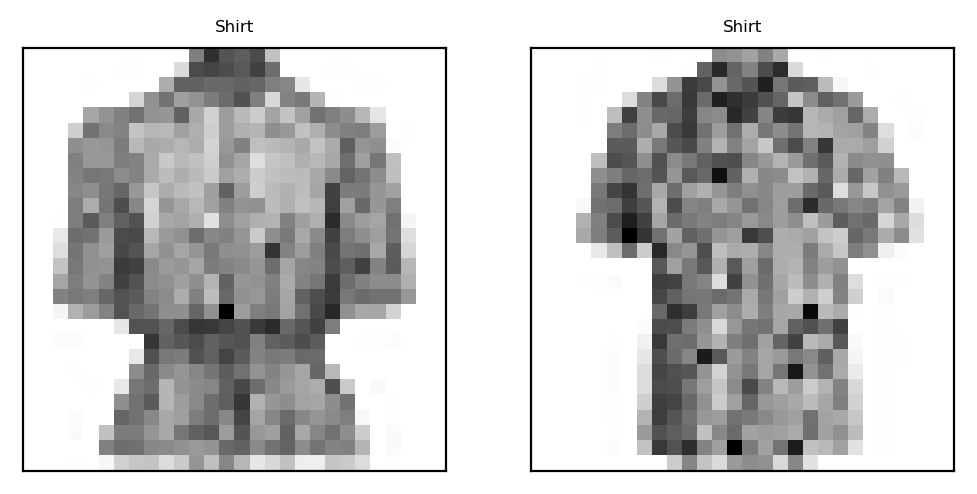

In [153]:
# Example code for finding a neighbors based on the neural codes 
# Select a random image from the dataset 
index = 123
# Get its neural code
print("Neural code: ", neural_codes[index])
# Get its closest neighbor
index_neighbor = get_closest_neighbor(neural_codes[index])

# Build the figure
subfiglist = []
titles = []
subfiglist.append(np.squeeze(dataset_2[index], axis=2))
titles.append(fmnist_classes[np.argmax(y_dataset2[index])])
subfiglist.append(np.squeeze(dataset_2[index_neighbor], axis=2))
titles.append(fmnist_classes[np.argmax(y_dataset2[index_neighbor])])

buildFigureList(plt.figure(1),subfiglist, titles, 2)

### d) Analyze a cluster computed by k-means (2 Points)
- Run k-means on neural code from Dataset 2 with k=5 using k-means++ and random_state=0
- Compute and show a confusion matrix of the clusters with respect to the original labels.